**Name: Ali Asghar**

**5122740**

**Portfolio2 Part1**

**Kalman FIlter**

**Kalman Filter Implementation**

In [7]:
import numpy as np
import matplotlib.pyplot as plt


g = 9.81  # gravity acceleration (m/s^2)
class KalmanFilter:
    def __init__(self, dt, initial_state, initial_covariance, transition_cov, observation_cov):
        # Initialize the Kalman filter parameters
        self.dt = dt
        self.state = np.array(initial_state)
        self.P = np.array(initial_covariance)
        self.Q = np.array(transition_cov)
        self.R = np.array(observation_cov)
        self.F = np.array([[1, 0, dt, 0],
                           [0, 1, 0, dt],
                           [0, 0, 1, 0],
                           [0, 0, 0, 1]])
        self.H = np.array([[1, 0, 0, 0],
                           [0, 1, 0, 0]])

    def predict(self):
        # Predict the next state and covariance
        self.state = self.F @ self.state
        self.P = self.F @ self.P @ self.F.T + self.Q

    def update(self, observation):
         # Update the state and covariance with a new observation
        if observation is not None:
            y = np.array(observation) - self.H @ self.state
            S = self.H @ self.P @ self.H.T + self.R
            K = self.P @ self.H.T @ np.linalg.inv(S)
            self.state = self.state + K @ y
            self.P = self.P - K @ self.H @ self.P

    def get_state(self):
        return self.state

**Ball Trajectory of Kalman Filter**

In [8]:
"""
    Simulate the true trajectory of the ball based on launch parameters.

    launch_position: Initial position (x, y).
    launch_speed: Initial speed of the ball.
    launch_angle: Launch angle in degrees.
    time_step: Time increment for simulation.
    total_time: Total time of simulation.

    """

def simulate_ball_trajectory(launch_position, launch_speed, launch_angle, time_step, total_time):


    launch_angle_rad = np.radians(launch_angle)
    initial_velocity_x = launch_speed * np.cos(launch_angle_rad)
    initial_velocity_y = launch_speed * np.sin(launch_angle_rad)

    times = np.arange(0, total_time, time_step)
    true_positions = []
    actual_velocities = []

    for t in times:
        x = initial_velocity_x * t
        y = launch_position[1] + initial_velocity_y * t - 0.5 * g * t**2
        true_positions.append((x, y))
        actual_velocities.append((initial_velocity_x, initial_velocity_y - g * t))

    return np.array(true_positions), np.array(actual_velocities), times


**Handle Noisy Observation**

In [9]:
"""
   Simulate noisy observations based on the true positions with the option to skip observations.

    true_positions: True positions of the ball.
    observation_noise_cov: Covariance matrix of the observation noise.
    skip_observations: Boolean to indicate if observations should be skipped.
    skip_ob_start_time: Start time for skipping observations.
    skip_ob_stop_time: Stop time for skipping observations.
    times: Array of time points.
    """

def simulate_noisy_observations(true_positions, observation_noise_cov, skip_observations, skip_ob_start_time, skip_ob_stop_time, times):

    noisy_positions = []
    for t, pos in zip(times, true_positions):
        if skip_observations and skip_ob_start_time <= t <= skip_ob_stop_time:
            noisy_positions.append(None)
        else:
            noisy_pos = pos + np.random.multivariate_normal([0, 0], observation_noise_cov)
            noisy_positions.append(noisy_pos)
    return noisy_positions

**Kalman Filter Simualtion plot Function**

In [10]:
def simulate_and_plot_trajectory(launch_position, launch_speed, launch_angle, time_step, total_time,
                      observation_noise, skip_observations, skip_ob_start_time, skip_ob_stop_time,
                      transition_cov_scale):
    # Observation noise covariance matrix
    observation_noise_cov = np.array([[observation_noise, 0], [0, observation_noise]])
    initial_state = [launch_position[0], launch_position[1],
                     launch_speed * np.cos(np.radians(launch_angle)), launch_speed * np.sin(np.radians(launch_angle))]
    initial_covariance = np.eye(4)

    # Process noise covariance matrix
    transition_cov = transition_cov_scale * np.eye(4)

    # Measurement noise covariance matrix
    observation_cov = observation_noise_cov

     # Simulate the ball trajectory and noisy observations
    true_positions, actual_velocities, times = simulate_ball_trajectory(launch_position, launch_speed, launch_angle, time_step, total_time)
    noisy_observations = simulate_noisy_observations(true_positions, observation_noise_cov, skip_observations, skip_ob_start_time, skip_ob_stop_time, times)

    # Initialize Kalman Filter
    kf = KalmanFilter(time_step, initial_state, initial_covariance, transition_cov, observation_cov)

    estimated_states = []
    predicted_observations = []
    predicted_velocities = []

    # Print the header for the time step information
    #print(f"{'Time':>8} {'Actual Observation':>25} {'Estimated State':>50}")

    for t, obs in zip(times, noisy_observations):
        kf.predict()
        kf.update(obs)
        estimated_state = kf.get_state()
        estimated_states.append(estimated_state)
        predicted_observations.append(kf.H @ estimated_state)
        predicted_velocities.append(estimated_state[2:])

        # Print the actual observation and estimated state for each time step
        print(f"Time: {t:.2f} Ball 1:")
        print(f"  Actual Observation: {obs if obs is not None else 'None'}")
        print(f"  Estimated State: {estimated_state}")

    estimated_states = np.array(estimated_states)
    predicted_observations = np.array(predicted_observations)
    predicted_velocities = np.array(predicted_velocities)

    # Plotting the results
    plot_results(true_positions, noisy_observations, estimated_states, predicted_observations,
                 predicted_velocities, actual_velocities, times)



In [11]:
"""
    Plot the results of the simulation and Kalman Filter.

    true_positions: True positions of the ball.
    noisy_observations: Noisy observations of the ball.
    estimated_states: States estimated by the Kalman Filter.
    predicted_observations: Observations predicted by the Kalman Filter.
    predicted_velocities: Velocities predicted by the Kalman Filter.
    actual_velocities: True velocities of the ball.
    times: Array of time points.
    """

def plot_results(true_positions, noisy_observations, estimated_states, predicted_observations,
                 predicted_velocities, actual_velocities, times):

    plt.figure(figsize=(10, 6))
    plt.plot(times, [obs[1] if obs is not None else np.nan for obs in noisy_observations], 'bo', label='Actual Y Observation', markersize=5)
    plt.plot(times, predicted_observations[:, 1], 'k--', label='Predicted Y Observation')
    plt.plot(times, actual_velocities[:, 0], 'C2--', label='Actual X Velocity')
    plt.plot(times, actual_velocities[:, 1], 'C1--', label='Actual Y Velocity')
    plt.plot(times, predicted_velocities[:, 0], 'C2', label='Predicted X Velocity')
    plt.plot(times, predicted_velocities[:, 1], 'C1', label='Predicted Y Velocity')
    plt.plot(times, true_positions[:, 1], 'r', label='True Y Position', linewidth=2)

    plt.xlabel('Time', fontsize=12)
    plt.ylabel('Observation / Velocity / Position', fontsize=12)
    plt.title('Ball Trajectory Simulation', fontsize=14)
    plt.legend(fontsize=10)
    plt.grid()
    plt.show()

**Experiment with differnet parameters Values**

Time: 0.00 Ball 1:
  Actual Observation: [0.75631631 9.31845209]
  Estimated State: [ 5.82300932 11.72609673 69.69733952 70.22914919]
Time: 0.10 Ball 1:
  Actual Observation: [ 7.38461574 18.42423084]
  Estimated State: [10.19587401 18.59305873 68.90774263 70.18173058]
Time: 0.20 Ball 1:
  Actual Observation: [13.65537483 25.27317703]
  Estimated State: [15.63551344 25.46826357 68.15398522 70.10746915]
Time: 0.30 Ball 1:
  Actual Observation: [22.16553102 31.50288218]
  Estimated State: [22.33424789 32.07996806 68.0753686  69.83856573]
Time: 0.40 Ball 1:
  Actual Observation: [29.75776082 35.76740894]
  Estimated State: [29.39311459 37.71882489 68.26824388 68.8063875 ]
Time: 0.50 Ball 1:
  Actual Observation: [35.55387136 43.4244938 ]
  Estimated State: [35.94652287 44.11714672 68.04442556 68.41156306]
Time: 0.60 Ball 1:
  Actual Observation: [41.76240022 50.75949059]
  Estimated State: [42.34272356 50.87620064 67.69984611 68.34226396]
Time: 0.70 Ball 1:
  Actual Observation: [49.45649

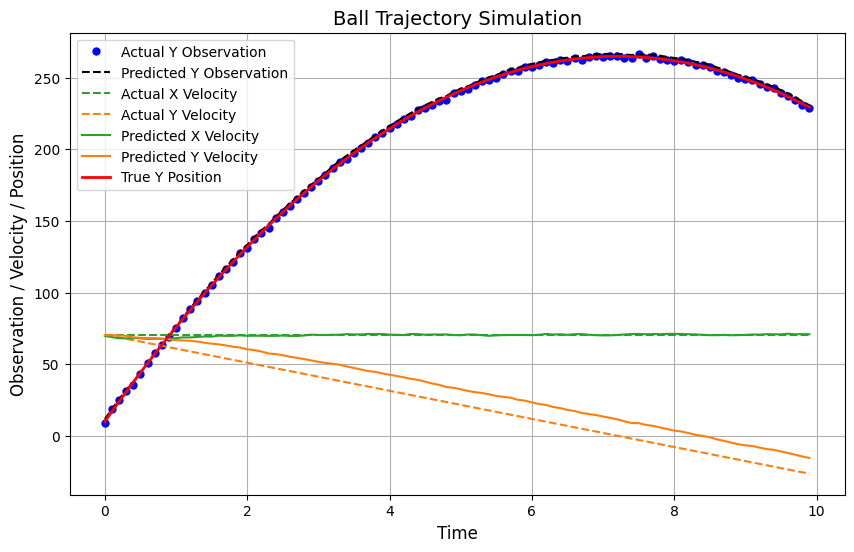

In [14]:
def main():
    # Simulation parameters
    launch_position = [10, 10]
    launch_speed = 100
    launch_angle = 45
    time_step = 0.1
    total_time = 10.0

    # Observation parameters
    observation_noise = 0.5
    skip_observations = False
    skip_ob_start_time = 2
    skip_ob_stop_time = 7

    # Kalman Filter parameters
    transition_cov_scale = 0.1

    # Run simulation and plotting
    simulate_and_plot_trajectory(launch_position, launch_speed, launch_angle, time_step, total_time,
                      observation_noise, skip_observations, skip_ob_start_time, skip_ob_stop_time,
                      transition_cov_scale)


if __name__ == "__main__":
    main()
